# Clustering Centers and Scores
### $Time$ $Series$ $4th$ $Test$

$Vasco$ $Mergulhão$ $-$ $April$ $2023$

### Version 1:
This script calcules the clusters centers and respective scores according to different simillarity measures:
- Euclidean
- DTW
- kMedoids-DTW

In [1]:
from dtaidistance.dtw_barycenter import dba_loop as dba_centre
from sktime.clustering.k_medoids import TimeSeriesKMedoids
from tslearn.barycenters import euclidean_barycenter as euc_center

from dtaidistance.ed import distance as euc_dist
from dtaidistance.dtw import distance_fast as dtw_dist
from sktime.clustering.k_medoids import TimeSeriesKMedoids

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import time
from tqdm.auto import tqdm
import os
from itertools import cycle
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import Transform

---
# Script Variabels

In [3]:
dataset_name = 'Kenya_90k_Set_1_w90_pW'
solution_name = 'FC_N2D-sage_sweep_1_v90'

In [4]:
dataset_folder = "_".join(dataset_name.split('_')[:-2]) 
dataset_location = f'../Data_Storage_Processing/Data/{dataset_folder}/{dataset_name}.csv'

sol_location = f'../ModelResults/Clustering/Solutions/{dataset_name}/{solution_name}.csv'

window_cols, window_len = Transform.retrive_window_col_names(dataset_name)

---
# Data Imports

In [5]:
df_data = pl.read_csv(dataset_location)

---
# Ploting Functions

In [6]:
def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

In [7]:
def plot_elbow(df_centers, alg = 'kMeans', mode = 'Total_Score', line_type = 'avg'):
    
    df = df_centers[df_centers['Algorithm'] == alg]
    
    if line_type == 'avg': 
        df_line = df_centers[Euclidean_centres['Algorithm']==alg][['k', mode]].groupby('k').agg('mean').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        
    elif line_type == 'w_avg':
        df_line = df_centers[Euclidean_centres['Algorithm']==alg][['Cluster_Size', 'k', mode]].groupby('k').apply(w_avg, mode, 'Cluster_Size').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        df_line.rename(columns={0: mode}, inplace=True)    
    
    elif line_type == 'sum':
        df_line = df_centers[Euclidean_centres['Algorithm']==alg][['k', mode]].groupby('k').agg('sum').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        
    
    fig = go.Figure()

    fig.add_trace(
        go.Box(
            y=df[mode],
            x=df['k'],
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.5,
            fillcolor='rgba(93, 164, 214, 0.5)',
            marker_size=3,
            line_width=1.5,
        )
    )
        
    fig.add_trace(
        go.Scatter(
            x=df_line['k'],
            y=df_line[mode],
            mode = 'lines+markers',
            name = 'Average',
            marker_color='rgba(128, 0, 0, .6)'
        )
    )
        
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        template="seaborn",
        showlegend = False
    )
    
    fig.show()

In [8]:
def plot_cluster_samples (df_centers, df_data, mode = 'Total_Score', alg = 'kMeans', k = 'k10', cluster = 1, sample = 10, seed = 42):
    
    df_center = df_centers[(df_centers['Algorithm'] == alg) & (df_centers['k'] == k) & (df_centers['cluster'] == cluster)]
    center = df_center[window_cols].values.ravel()
    
    sol = ('_').join([alg, k])    
    df_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == cluster).select(["short_ID", "window_ID"]).collect().sample(n=sample, seed=seed)  
    df_samples = df_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
    samples = df_samples[window_cols].values
    
    fig = go.Figure()
       
    # Samples
    for sample in samples:
        fig.add_trace(
            go.Scatter(
                x = window_cols,
                y = sample,
                mode = 'lines',
                name = 'Average',
                marker_color='rgba(36, 37, 42, .25)',
                hoverinfo='skip'
            )
        )    
        
    # Center Line
    fig.add_trace(
        go.Scatter(
            x = window_cols,
            y = center,
            mode = 'lines',
            name = 'Cluster Center',
            line=dict(color='rgba(217, 30, 24, .8)', width=3.5),
            hovertemplate='%{y:.2f}',
        )
    )
 
    
    # Figure Style
    fig.update_layout(
        margin=dict(l=5, r=20, t=30, b=20),
        template="ggplot2",
        showlegend = False,
        hovermode = 'x',
        title={
            'text': f'<b>Cluster: {cluster}</b> - {alg}_{k}',
            'xanchor': 'center',
            'yanchor': 'middle',
        },
        title_font={
            'family': 'Garamond',#"Courier New, monospace", Franklin Gothic
            'size':18
        },
        font = {
            'family': 'Times New Roman',#"Courier New, monospace", Franklin Gothic
            'size':14
        },
        plot_bgcolor='rgba(252, 251, 242, 1)',
        paper_bgcolor = 'white'
    )
    
    fig.show()

In [9]:
def plot_centers(df_centers, alg = 'kMeans', k = 'k10'):
    
    df = df_centers[(df_centers['Algorithm'] == alg) & (df_centers['k'] == k)]
    sol_cols = pl.scan_csv(sol_location).columns[5:]

    max_c = int(sol_cols[-1].split('_')[-1][1:])

    fig = go.Figure()
    for c in range(1, max_c +1):
        fig.add_trace(
            go.Scatter(
                x=window_cols,
                y= df[df['cluster'] == c][window_cols].values.ravel(),
                mode='lines',
                name= f'Cluster: {c}'
            )
        )
        
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        template="seaborn",
        showlegend = True 
    )


    fig.show()
    

In [10]:
def plot_flow(df_data, alg = 'kMeans', k = 'k10', sample = 1000, groupnorm = 'percent'):
    
    sol = ('_').join([alg, k])   
    if sample == 'all':
        df_ids = pl.scan_csv(sol_location).select(["short_ID", "window_ID", sol]).collect()
    else:
        df_ids = pl.scan_csv(sol_location).select(["short_ID", "window_ID", sol]).fetch(sample)  
        
    df = df_ids.join(df_data[['short_ID', 'window_ID', 'window_start_date']], on = ['short_ID', 'window_ID'], how='left').to_pandas()
    df = df[['short_ID', 'window_ID', 'window_start_date', sol]]

    df['window_start_date'] = pd.to_datetime(df['window_start_date'])   
    df = df.set_index('window_start_date').groupby('short_ID').resample('1D').mean().reset_index(level='short_ID', drop=True).astype('Int64', errors = 'ignore').reset_index().fillna(method='ffill')
    
    cmin = df[sol].min()
    cmax = df[sol].max()
    
    palette = cycle(px.colors.qualitative.T10)
    fig = go.Figure()
    for c in range(cmin, cmax+1):
        cluster_count = df[df[sol]==c].groupby('window_start_date')[sol].count()
    
        fig.add_trace(
            go.Scatter(
                x=cluster_count.index,
                y=cluster_count.values,
                fill='tonexty',
                mode= 'lines',
                name = f'Cluster: {c}',
                stackgroup = 'one',
                groupnorm=groupnorm,
                hovertemplate='%{y:.1f}',
                line=dict(width=0, color=next(palette))
            )
        )
        
    # Figure Style
    sol_name = solution_name.split('-')[0]
    if groupnorm == 'percent':
        graph_mode = 'Percentage'
    else:
        graph_mode = 'Total Count'
        
    fig.update_layout(
        margin=dict(l=5, r=20, t=30, b=20),
        template="plotly_white",
        showlegend = True,
        legend = {
            'y': 0.5,
            'yanchor': 'middle',
        },
        hovermode = 'x',
        title={
            'text': f'{graph_mode}: <b>{sol_name} {alg} (k={k[1:]})</b>',
            'x': .5,
            'xanchor': 'center',
            'yanchor': 'middle',
        },
        title_font={
            'family': 'Garamond',#"Courier New, monospace", Franklin Gothic
            'size':18
        },
        font = {
            'family': 'Times New Roman',#"Courier New, monospace", Franklin Gothic
            'size':14
        },
        plot_bgcolor='rgba(252, 251, 242, 1)',
        paper_bgcolor = 'white'
    )

    fig.show()

---
# Flow Charts

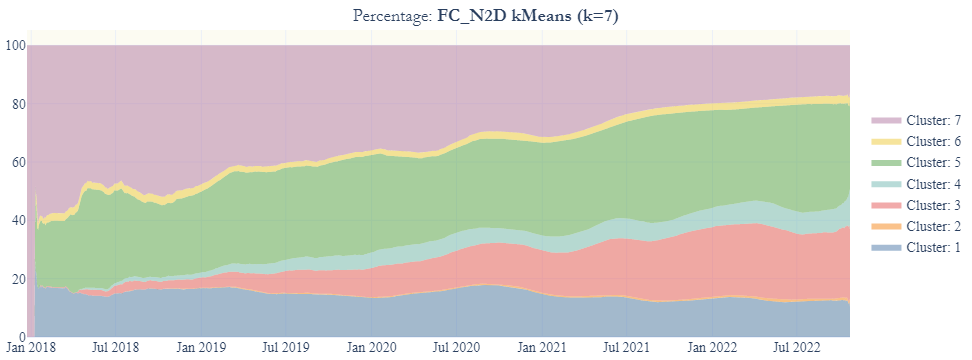

In [11]:
plot_flow(df_data, alg = 'kMeans', k='k7', groupnorm = 'percent', sample = 'all')

In [12]:
plot_flow(df_data, alg = 'kMeans', k='k7', groupnorm = None, sample = 'all')

---
# Gini Index
see <code>Exploration_Gini</code> notebook

In [14]:
def gini_index (x):
    # https://en.wikipedia.org/wiki/Gini_coefficient#cite_note-23
    # Alternative expressions
    
    # x must be 1-d array of distances
    x = np.float64(x)
    # x is sorted in the function
    x = np.sort(x)
    sum_x = x.cumsum()[-1]
    
    ix = x * np.arange(1, len(x)+1)
    sum_ix = ix.cumsum()[-1]

    n = len(x)
        
    total = ((2 * sum_ix) / (n * sum_x)) - (n+1)/n
        
    return total

---
# Euclidean
https://dtaidistance.readthedocs.io/en/latest/usage/ed.html  
https://tslearn.readthedocs.io/en/stable/gen_modules/barycenters/tslearn.barycenters.euclidean_barycenter.html#tslearn.barycenters.euclidean_barycenter  

In [21]:
sol_cols = pl.scan_csv(sol_location).columns[5:]
# Calc total number of clusters
max_c = int(sol_cols[-1].split('_')[-1][1:])
algo_types = len(set([sol.split('_')[0] for sol in sol_cols]))
total_c = int(algo_types * (max_c * (max_c + 1) / 2) - 2)

# initiating lists
centroids = []
algorithms = []
k = []
clusters = []
avg_scores = []
cum_p95 = []
cum_p99 = []
gini = []
p95 = []
p99 = []
qsc = []
total_scores = []
n_w_cluster = []
i = 0
for s, sol in tqdm(enumerate(sol_cols), total=len(sol_cols),desc= 'Total Progress', leave = True, unit="epoch"):
    # Getting range of clusters for sol
    c_min = 1
    c_max = int(sol.split('_')[-1][1:]) # pl.scan_csv(sol_location).select(pl.max(f'{sol}')).collect().item()

    # Calculating Centroid/Barycenter per cluster per sol.
    for c in tqdm(range(c_min, c_max + 1), desc= f'{sol}', leave = False, unit="epoch"):
        i += 1
        # Getting relevant windows (cluster points)
        df_sol_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == c).select(["short_ID", "window_ID"]).collect()
        df_sol = df_sol_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
        sol_data = df_sol[window_cols].values
        
        n_w_cluster.append(len(sol_data))

        
        # Calculating cluster centre
        centroid = euc_center(sol_data).ravel()
        # Saving cluster centre
        centroids.append(centroid)
        
        # Saving Algorithm and k values
        algorithms.append(sol.split('_')[0])
        k.append(sol.split('_')[-1])
        clusters.append(c)
        
        # Calculating Average Score for respective metric
        scores = []
        for window in sol_data:
            score = euc_dist(centroid, window)
            scores.append(score)
        scores = np.abs(scores)
        total_scores.append(np.sum(scores))
        avg_scores.append(np.mean(scores))
        
        cum_p95.append(np.sum(np.where(scores <= np.percentile(scores, 95), scores, 0)))
        cum_p99.append(np.sum(np.where(scores <= np.percentile(scores, 99), scores, 0)))
        gini.append(gini_index(scores))
        
        p95.append(np.percentile(scores, 95))
        p99.append(np.percentile(scores, 99))
        q1, q2, q3 = np.percentile(scores, [25, 50, 75])
        if q3 - q1 == 0:
            qsc.append(0)
        else:
            qsc.append((q3 + q1 - 2*q2) / (q3 - q1))
        
        
Euclidean_centres = pd.DataFrame(centroids, columns=window_cols)
Euclidean_centres.insert(0, "cluster", clusters)
Euclidean_centres.insert(0, "k", k)
Euclidean_centres.insert(0, "Algorithm", algorithms)
Euclidean_centres.insert(3, "Avg_Score", avg_scores)
Euclidean_centres.insert(3, "p95", p95)
Euclidean_centres.insert(3, "p99", p99)
Euclidean_centres.insert(3, "QSC", qsc)
Euclidean_centres.insert(3, "Sum_p95", cum_p95)
Euclidean_centres.insert(3, "Sum_p99", cum_p99)
Euclidean_centres.insert(3, "Gini", gini)
Euclidean_centres.insert(3, "Total_Score", total_scores)
Euclidean_centres.insert(3, "Cluster_Size", n_w_cluster)

Total Progress:   0%|          | 0/48 [00:00<?, ?epoch/s]

kMeans_k2:   0%|          | 0/2 [00:00<?, ?epoch/s]

kMeans_k3:   0%|          | 0/3 [00:00<?, ?epoch/s]

kMeans_k4:   0%|          | 0/4 [00:00<?, ?epoch/s]

kMeans_k5:   0%|          | 0/5 [00:00<?, ?epoch/s]

kMeans_k6:   0%|          | 0/6 [00:00<?, ?epoch/s]

kMeans_k7:   0%|          | 0/7 [00:00<?, ?epoch/s]

kMeans_k8:   0%|          | 0/8 [00:00<?, ?epoch/s]

kMeans_k9:   0%|          | 0/9 [00:00<?, ?epoch/s]

kMeans_k10:   0%|          | 0/10 [00:00<?, ?epoch/s]

kMeans_k11:   0%|          | 0/11 [00:00<?, ?epoch/s]

kMeans_k12:   0%|          | 0/12 [00:00<?, ?epoch/s]

kMeans_k13:   0%|          | 0/13 [00:00<?, ?epoch/s]

kMeans_k14:   0%|          | 0/14 [00:00<?, ?epoch/s]

kMeans_k15:   0%|          | 0/15 [00:00<?, ?epoch/s]

kMeans_k16:   0%|          | 0/16 [00:00<?, ?epoch/s]

kMeans_k17:   0%|          | 0/17 [00:00<?, ?epoch/s]

kMeans_k18:   0%|          | 0/18 [00:00<?, ?epoch/s]

kMeans_k19:   0%|          | 0/19 [00:00<?, ?epoch/s]

kMeans_k20:   0%|          | 0/20 [00:00<?, ?epoch/s]

kMeans_k21:   0%|          | 0/21 [00:00<?, ?epoch/s]

kMeans_k22:   0%|          | 0/22 [00:00<?, ?epoch/s]

kMeans_k23:   0%|          | 0/23 [00:00<?, ?epoch/s]

kMeans_k24:   0%|          | 0/24 [00:00<?, ?epoch/s]

kMeans_k25:   0%|          | 0/25 [00:00<?, ?epoch/s]

KUMAP_k2:   0%|          | 0/2 [00:00<?, ?epoch/s]

KUMAP_k3:   0%|          | 0/3 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k4:   0%|          | 0/4 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k5:   0%|          | 0/5 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k6:   0%|          | 0/6 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k7:   0%|          | 0/7 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k8:   0%|          | 0/8 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k9:   0%|          | 0/9 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k10:   0%|          | 0/10 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k11:   0%|          | 0/11 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k12:   0%|          | 0/12 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k13:   0%|          | 0/13 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k14:   0%|          | 0/14 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k15:   0%|          | 0/15 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k16:   0%|          | 0/16 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k17:   0%|          | 0/17 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k18:   0%|          | 0/18 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k19:   0%|          | 0/19 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k20:   0%|          | 0/20 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k21:   0%|          | 0/21 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k22:   0%|          | 0/22 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k23:   0%|          | 0/23 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k24:   0%|          | 0/24 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k25:   0%|          | 0/25 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



In [23]:
Euclidean_centres.tail(9)

Algorithm    k  cluster  Cluster_Size  Total_Score      Gini      Sum_p99  \
639     KUMAP  k25       17          1000  3918.372285  0.061166  3864.768763   
640     KUMAP  k25       18          1000  3811.409704  0.092167  3636.275498   
641     KUMAP  k25       19           168    55.106667  0.500837    39.965679   
642     KUMAP  k25       20          1000  3819.965991  0.074794  3767.466305   
643     KUMAP  k25       21           262     0.281923  0.603604     0.132053   
644     KUMAP  k25       22           176    92.014838  0.485174    76.702486   
645     KUMAP  k25       23           169    65.319282  0.515751    50.263669   
646     KUMAP  k25       24           595     7.717297  0.504100     6.692649   
647     KUMAP  k25       25          1000  3754.296098  0.088849  3693.873074   

         Sum_p95       QSC       p99  ...       d81       d82       d83  \
639  3672.644386 -0.052330  5.029462  ...  0.069874  0.061103  0.059173   
640  3450.766542  0.002232  5.280921  ...  0.239008  0.250050  0.244418   
641    28.500443  0.000000  7.561669  ... -7.000000 -7.000000 -7.000000   
642  3572.615184 -0.020990  5.063557  ... -0.314827 -0.326948 -0.320650   
643     0.107457  0.000000  0.015105  ...  2.000000  1.999980  2.000000   
644    54.167629  0.000000  7.441373  ... -7.000000 -7.000000 -7.000000   
645    30.169818  0.000000  7.268068  ... -7.000000 -7.000000 -7.000000   
646     5.334914  0.007738  0.128285  ... -0.254742 -0.254742 -0.254742   
647  3504.076296 -0.155402  5.027748  ... -0.501851 -0.492780 -0.484736   

          d84       d85       d86       d87       d88       d89       d90  
639  0.049931  0.042677  0.042961  0.024106  0.016051  0.013108  0.007490  
640  0.239503  0.229875  0.226807  0.217534  0.205618  0.204988  0.205763  
641 -7.000000 -7.000000 -7.000000 -7.000000 -7.000000  2.000000  1.926516  
642 -0.302133 -0.276964 -0.237007 -0.208670 -0.194276 -0.184165 -0.185645  
643  2.000000  2.000000  2.000000  2.000000  2.000000  1.999980  2.000000  
644 -7.000000 -7.000000 -7.000000 -7.000000  2.000000  1.948580  1.824289  
645 -7.000000 -7.000000 -7.000000  1.988385  1.989451  1.978526  1.990402  
646 -0.254742 -0.254742 -0.254742 -0.254742 -0.254742 -0.254742 -0.254742  
647 -0.482092 -0.473039 -0.454294 -0.428465 -0.398629 -0.389204 -0.365115  

[9 rows x 102 columns]

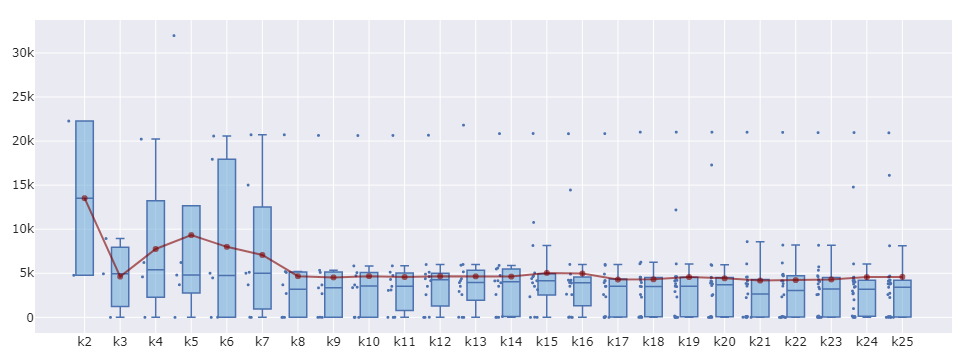

In [26]:
plot_elbow(Euclidean_centres, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

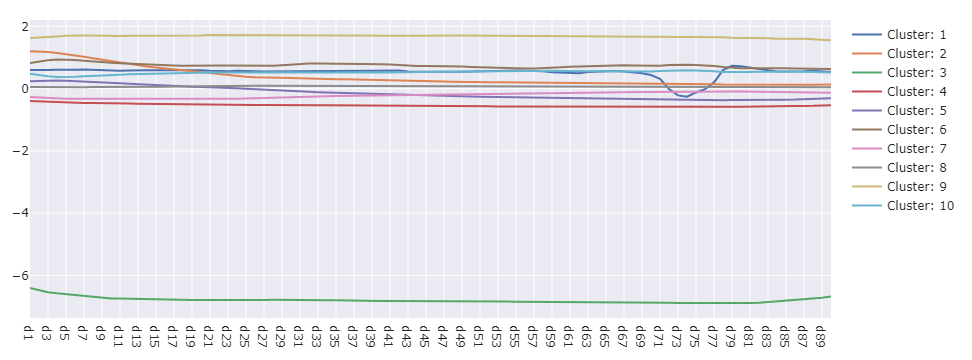

In [14]:
plot_centers(Euclidean_centres, alg='kMeans', k = 'k10')

In [15]:
('_').join(['kMeans', 'k10'])  

'kMeans_k10'

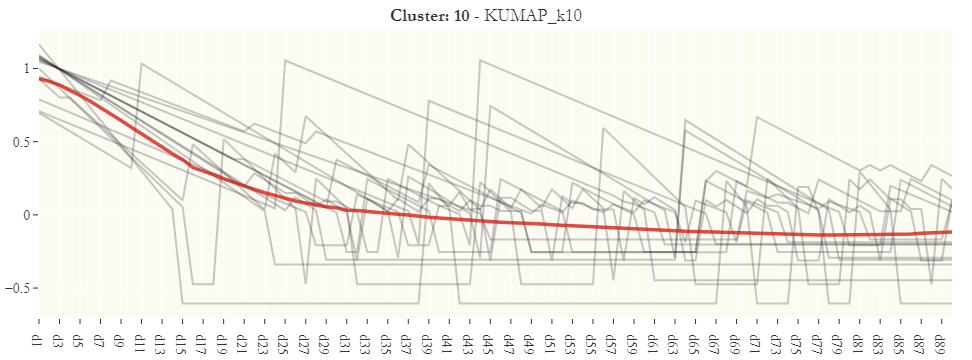

In [16]:
plot_cluster_samples(Euclidean_centres, df_data, alg = 'KUMAP', k = 'k10', cluster=10, sample=15, seed=42)

---
# DTW & *"kMedoid"*
https://dtaidistance.readthedocs.io/en/latest/modules/dtw_barycenter.html  
https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html#dtw-between-multiple-time-series

In [27]:
sol_cols = pl.scan_csv(sol_location).columns[5:]
# Calc total number of clusters
max_c = int(sol_cols[-1].split('_')[-1][1:])
algo_types = len(set([sol.split('_')[0] for sol in sol_cols]))
total_c = int(algo_types * (max_c * (max_c + 1) / 2) - 2)

# initiating lists
algorithms = []
k = []
clusters = []
n_w_cluster = []

dba_centroids = []
dtw_avg_scores = []
dtw_total_scores = []
dtw_cum_p95 = []
dtw_cum_p99 = []
dtw_gini = []
dtw_p95 = []
dtw_p99 = []
dtw_qsc = []

dtai_kmedoids = []
kmedoid_total_scores = []
kmedoid_avg_scores = []
kmedoid_cum_p95 = []
kmedoid_cum_p99 = []
kmedoid_gini = []
kmedoid_p95 = []
kmedoid_p99 = []
kmedoid_qsc = []

i = 0
for s, sol in tqdm(enumerate(sol_cols), total=len(sol_cols),desc= 'Total Progress', leave = True, unit="epoch"):
    # Getting range of clusters for sol
    c_min = 1
    c_max = int(sol.split('_')[-1][1:]) 

    # Calculating Centroid/Barycenter per cluster per sol.
    for c in tqdm(range(c_min, c_max + 1), desc= f'{sol}', leave = False, unit="epoch"):
        i += 1
        # Getting relevant windows (cluster points)
        df_sol_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == c).select(["short_ID", "window_ID"]).collect()
        df_sol = df_sol_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
        sol_data = df_sol[window_cols].values
        
        n_w_cluster.append(len(sol_data))
        
        # Calculating DTW cluster centre
        dba_centroid = dba_centre(sol_data, max_it=10, thr=0.001, use_c=True)
        # Saving DTW cluster centre
        dba_centroids.append(dba_centroid)
        
        # Saving Algorithm and k values
        algorithms.append(sol.split('_')[0])
        k.append(sol.split('_')[-1])
        clusters.append(c)
        
        # Calculating Average Score for DTW
        dtw_scores = []
        for window in sol_data:
            dtw_score = dtw_dist(dba_centroid, window)
            dtw_scores.append(dtw_score)
        dtw_total_scores.append(np.sum(np.abs(dtw_scores)))
        dtw_avg_scores.append(np.mean(np.abs(dtw_scores)))
        
        dtw_cum_p95.append(np.sum(np.where(dtw_scores <= np.percentile(dtw_scores, 95), dtw_scores, 0)))
        dtw_cum_p99.append(np.sum(np.where(dtw_scores <= np.percentile(dtw_scores, 99), dtw_scores, 0)))
        dtw_gini.append(gini_index(dtw_scores))
        
        dtw_p95.append(np.percentile(dtw_scores, 95))
        dtw_p99.append(np.percentile(dtw_scores, 99))
        q1, q2, q3 = np.percentile(dtw_scores, [25, 50, 75])
        if q3 - q1 == 0:
            dtw_qsc.append(0)
        else:
            dtw_qsc.append((q3 + q1 - 2*q2) / (q3 - q1))

        
        
        # Identifying kMedoid
        idx_min = np.argmin(np.abs(dtw_scores))
        dtai_kmedoid = sol_data[idx_min]
        dtai_kmedoids.append(dtai_kmedoid)
        
        # Calculating Average Score for kMedoid (DTW)
        kmedoid_scores = []
        for window in sol_data:
            kmedoid_score = dtw_dist(dtai_kmedoid, window)
            kmedoid_scores.append(kmedoid_score)
        kmedoid_total_scores.append(np.sum(np.abs(kmedoid_scores)))
        kmedoid_avg_scores.append(np.mean(np.abs(kmedoid_scores)))
        
        kmedoid_cum_p95.append(np.sum(np.where(kmedoid_scores <= np.percentile(kmedoid_scores, 95), kmedoid_scores, 0)))
        kmedoid_cum_p99.append(np.sum(np.where(kmedoid_scores <= np.percentile(kmedoid_scores, 99), kmedoid_scores, 0)))
        kmedoid_gini.append(gini_index(kmedoid_scores))        
        
        kmedoid_p95.append(np.percentile(kmedoid_scores, 95))
        kmedoid_p99.append(np.percentile(kmedoid_scores, 99))
        q1, q2, q3 = np.percentile(kmedoid_scores, [25, 50, 75])
        if q3 - q1 == 0:
            kmedoid_qsc.append(0)
        else:
            kmedoid_qsc.append((q3 + q1 - 2*q2) / (q3 - q1))


        
        
DTW_centres = pd.DataFrame(dba_centroids, columns=window_cols)
DTW_centres.insert(0, "cluster", clusters)
DTW_centres.insert(0, "k", k)
DTW_centres.insert(0, "Algorithm", algorithms)
DTW_centres.insert(3, "Avg_Score", dtw_avg_scores)
DTW_centres.insert(3, "p95", dtw_p95)
DTW_centres.insert(3, "p99", dtw_p99)
DTW_centres.insert(3, "QSC", dtw_qsc)
DTW_centres.insert(3, "Sum_p95", dtw_cum_p95)
DTW_centres.insert(3, "Sum_p99", dtw_cum_p99)
DTW_centres.insert(3, "Gini", dtw_gini)
DTW_centres.insert(3, "Total_Score", dtw_total_scores)
DTW_centres.insert(3, "Cluster_Size", n_w_cluster)

        
DTAI_kMedoids_centres = pd.DataFrame(dtai_kmedoids, columns=window_cols)
DTAI_kMedoids_centres.insert(0, "cluster", clusters)
DTAI_kMedoids_centres.insert(0, "k", k)
DTAI_kMedoids_centres.insert(0, "Algorithm", algorithms)
DTAI_kMedoids_centres.insert(3, "Avg_Score", kmedoid_avg_scores)
DTAI_kMedoids_centres.insert(3, "p95", kmedoid_p95)
DTAI_kMedoids_centres.insert(3, "p99", kmedoid_p99)
DTAI_kMedoids_centres.insert(3, "QSC", kmedoid_qsc)
DTAI_kMedoids_centres.insert(3, "Sum_p95", kmedoid_cum_p95)
DTAI_kMedoids_centres.insert(3, "Sum_p99", kmedoid_cum_p99)
DTAI_kMedoids_centres.insert(3, "Gini", kmedoid_gini)
DTAI_kMedoids_centres.insert(3, "Total_Score", kmedoid_total_scores)
DTAI_kMedoids_centres.insert(3, "Cluster_Size", n_w_cluster)

Total Progress:   0%|          | 0/48 [00:00<?, ?epoch/s]

kMeans_k2:   0%|          | 0/2 [00:00<?, ?epoch/s]

kMeans_k3:   0%|          | 0/3 [00:00<?, ?epoch/s]

kMeans_k4:   0%|          | 0/4 [00:00<?, ?epoch/s]

kMeans_k5:   0%|          | 0/5 [00:00<?, ?epoch/s]

kMeans_k6:   0%|          | 0/6 [00:00<?, ?epoch/s]

kMeans_k7:   0%|          | 0/7 [00:00<?, ?epoch/s]

kMeans_k8:   0%|          | 0/8 [00:00<?, ?epoch/s]

kMeans_k9:   0%|          | 0/9 [00:00<?, ?epoch/s]

kMeans_k10:   0%|          | 0/10 [00:00<?, ?epoch/s]

kMeans_k11:   0%|          | 0/11 [00:00<?, ?epoch/s]

kMeans_k12:   0%|          | 0/12 [00:00<?, ?epoch/s]

kMeans_k13:   0%|          | 0/13 [00:00<?, ?epoch/s]

kMeans_k14:   0%|          | 0/14 [00:00<?, ?epoch/s]

kMeans_k15:   0%|          | 0/15 [00:00<?, ?epoch/s]

kMeans_k16:   0%|          | 0/16 [00:00<?, ?epoch/s]

kMeans_k17:   0%|          | 0/17 [00:00<?, ?epoch/s]

kMeans_k18:   0%|          | 0/18 [00:00<?, ?epoch/s]

kMeans_k19:   0%|          | 0/19 [00:00<?, ?epoch/s]

kMeans_k20:   0%|          | 0/20 [00:00<?, ?epoch/s]

kMeans_k21:   0%|          | 0/21 [00:00<?, ?epoch/s]

kMeans_k22:   0%|          | 0/22 [00:00<?, ?epoch/s]

kMeans_k23:   0%|          | 0/23 [00:00<?, ?epoch/s]

kMeans_k24:   0%|          | 0/24 [00:00<?, ?epoch/s]

kMeans_k25:   0%|          | 0/25 [00:00<?, ?epoch/s]

KUMAP_k2:   0%|          | 0/2 [00:00<?, ?epoch/s]

KUMAP_k3:   0%|          | 0/3 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k4:   0%|          | 0/4 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k5:   0%|          | 0/5 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k6:   0%|          | 0/6 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k7:   0%|          | 0/7 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k8:   0%|          | 0/8 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k9:   0%|          | 0/9 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k10:   0%|          | 0/10 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k11:   0%|          | 0/11 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k12:   0%|          | 0/12 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k13:   0%|          | 0/13 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k14:   0%|          | 0/14 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k15:   0%|          | 0/15 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k16:   0%|          | 0/16 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k17:   0%|          | 0/17 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k18:   0%|          | 0/18 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k19:   0%|          | 0/19 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k20:   0%|          | 0/20 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k21:   0%|          | 0/21 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k22:   0%|          | 0/22 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k23:   0%|          | 0/23 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k24:   0%|          | 0/24 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



KUMAP_k25:   0%|          | 0/25 [00:00<?, ?epoch/s]

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ucesvpm\AppData\Local\Temp\ipykernel_4680\3283681116.py:16: RuntimeWarning:

invalid value encountered in double_scalars



## DTW

In [28]:
DTW_centres.head(9)

Algorithm   k  cluster  Cluster_Size  Total_Score      Gini     Sum_p99  \
0    kMeans  k2        1           100   298.724093  0.170317  292.166705   
1    kMeans  k2        2           100   602.634130  0.223358  585.483297   
2    kMeans  k3        1           100   197.002294  0.153682  193.640720   
3    kMeans  k3        2           100   602.634130  0.223358  585.483297   
4    kMeans  k3        3           100   398.457137  0.266554  382.372646   
5    kMeans  k4        1           100   198.335781  0.179243  193.661142   
6    kMeans  k4        2           100   602.634130  0.223358  585.483297   
7    kMeans  k4        3           100   464.841871  0.271507  448.143805   
8    kMeans  k4        4           100   306.396675  0.207129  290.952156   

      Sum_p95       QSC        p99  ...       d81       d82       d83  \
0  271.266925  0.003647   5.409614  ...  0.462771  0.439211  0.499178   
1  520.346653  0.000000  17.111797  ... -7.000000 -7.000000 -7.000000   
2  181.175945  0.089484   3.251173  ... -0.581141 -0.581141 -0.581141   
3  520.346653  0.000000  17.111797  ... -7.000000 -7.000000 -7.000000   
4  382.372646  0.225894  10.119839  ...  1.188569  1.187319  1.184175   
5  178.771431  0.137266   3.878286  ...  0.343985  0.239615  0.213246   
6  520.346653  0.000000  17.111797  ... -7.000000 -7.000000 -7.000000   
7  400.494975  0.124371  12.362801  ...  1.387624  0.673812  1.771078   
8  266.110943  0.213268   7.746996  ...  0.715576  0.757198  0.681602   

        d84       d85       d86       d87       d88       d89       d90  
0  0.323714  0.677196  0.497397  0.436741  0.506740  0.212559 -0.529530  
1 -7.000000 -7.000000 -7.000000 -7.000000 -7.000000 -7.000000 -6.732673  
2 -0.581141 -0.573528 -0.587884  0.282830  0.018125 -0.697714  0.146720  
3 -7.000000 -7.000000 -7.000000 -7.000000 -7.000000 -7.000000 -6.732673  
4  1.041974  1.307131  1.204191  1.195941  1.050216  0.699818  0.312934  
5  0.252578  0.225164  0.239889  0.227761  0.164581  0.045806 -0.631737  
6 -7.000000 -7.000000 -7.000000 -7.000000 -7.000000 -7.000000 -6.732673  
7  1.654133  1.664537  1.619540  1.261604  1.600999  0.975540  1.869984  
8  0.388094  1.133875  0.839996  0.808172  0.779815  0.594529  0.236657  

[9 rows x 102 columns]

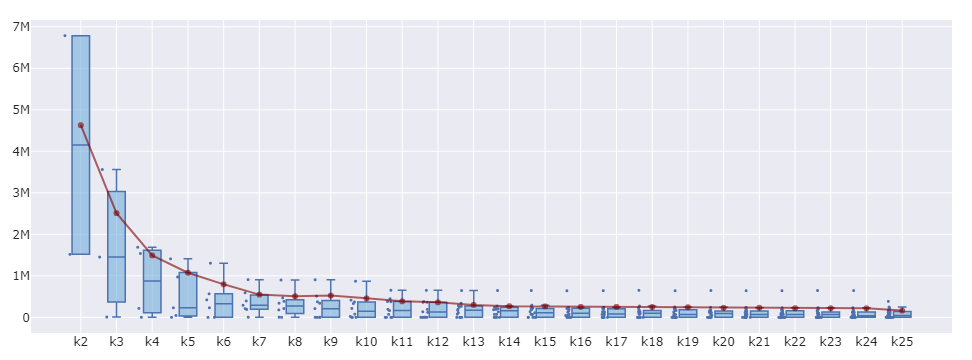

In [19]:
plot_elbow(DTW_centres, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

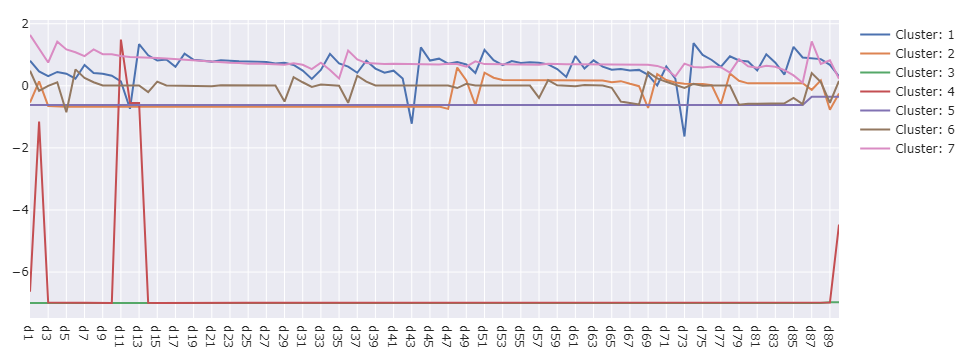

In [41]:
plot_centers(DTW_centres, alg='KUMAP', k = 'k7')

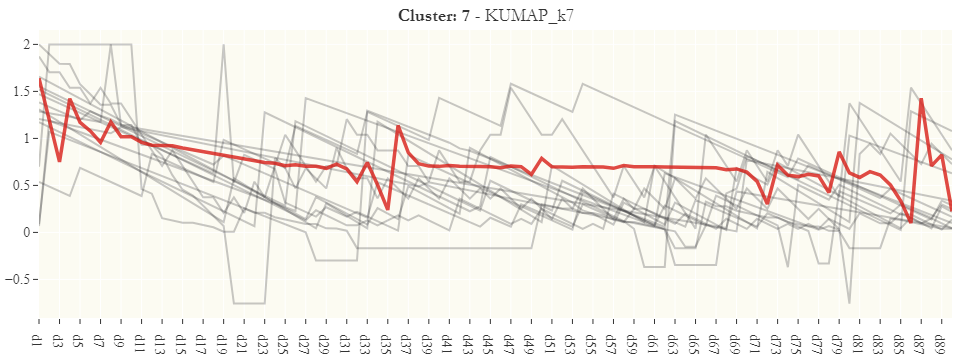

In [42]:
plot_cluster_samples(DTW_centres, df_data, alg = 'KUMAP', k = 'k7', cluster=7, sample=15, seed=42)

## *kMedoid*

In [29]:
DTAI_kMedoids_centres.head(9)

Algorithm   k  cluster  Cluster_Size  Total_Score      Gini     Sum_p99  \
0    kMeans  k2        1           100   403.498065  0.240652  391.385827   
1    kMeans  k2        2           100   371.557961  0.843723  344.955625   
2    kMeans  k3        1           100   260.899353  0.266616  254.684045   
3    kMeans  k3        2           100   371.557961  0.843723  344.955625   
4    kMeans  k3        3           100   452.882657  0.311659  434.476687   
5    kMeans  k4        1           100   254.697479  0.155354  249.896038   
6    kMeans  k4        2           100   371.557961  0.843723  344.955625   
7    kMeans  k4        3           100   532.168898  0.292384  513.974191   
8    kMeans  k4        4           100   396.383032  0.160935  380.560101   

      Sum_p95       QSC        p99  ...       d81       d82       d83  \
0  360.886520 -0.154455   9.254018  ... -0.596314 -0.596314 -0.596314   
1  245.339118  0.000000  26.591937  ... -7.000000 -7.000000 -7.000000   
2  233.663725  0.346937   5.494002  ...  0.425566  0.351131  0.351131   
3  245.339118  0.000000  26.591937  ... -7.000000 -7.000000 -7.000000   
4  434.476687  0.076241  12.264034  ...  0.870181  0.814625  0.759070   
5  233.573658 -0.016496   4.536933  ...  0.162073  0.070133  0.162073   
6  245.339118  0.000000  26.591937  ... -7.000000 -7.000000 -7.000000   
7  460.282607  0.436492  13.910648  ...  1.686740  1.686740  1.686740   
8  353.913648  0.179095   7.991259  ...  0.646729  0.531947  0.417165   

        d84       d85       d86       d87       d88       d89       d90  
0 -0.596314 -0.596314  0.563946  0.478758  0.393570  0.308383  0.223195  
1 -7.000000 -7.000000 -7.000000 -7.000000 -7.000000 -7.000000 -7.000000  
2  0.276696  0.202261  0.127826  0.053392 -0.521044 -0.521044  0.480476  
3 -7.000000 -7.000000 -7.000000 -7.000000 -7.000000 -7.000000 -7.000000  
4  0.703514  0.647958  0.592403  0.536847  0.481292  0.425736  0.370181  
5  0.070133 -0.643575 -0.643575 -0.643575 -0.643575 -0.643575 -0.643575  
6 -7.000000 -7.000000 -7.000000 -7.000000 -7.000000 -7.000000 -7.000000  
7  1.686740  1.686740  1.686740  1.686740  2.000000  2.000000  2.000000  
8  0.302384  0.991075  0.876293  0.761511  0.646729  0.531947  0.417165  

[9 rows x 102 columns]

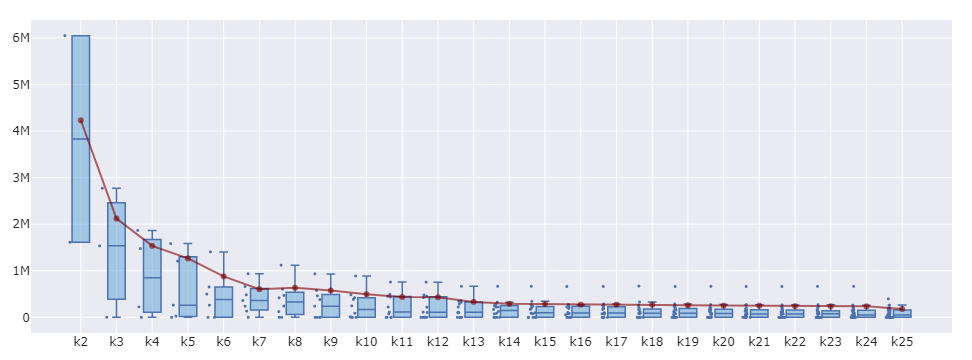

In [23]:
plot_elbow(DTAI_kMedoids_centres, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

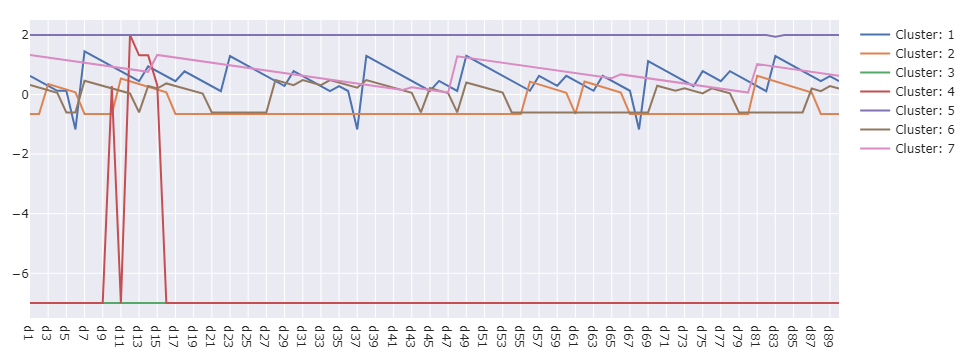

In [43]:
plot_centers(DTAI_kMedoids_centres, alg='KUMAP', k = 'k7')

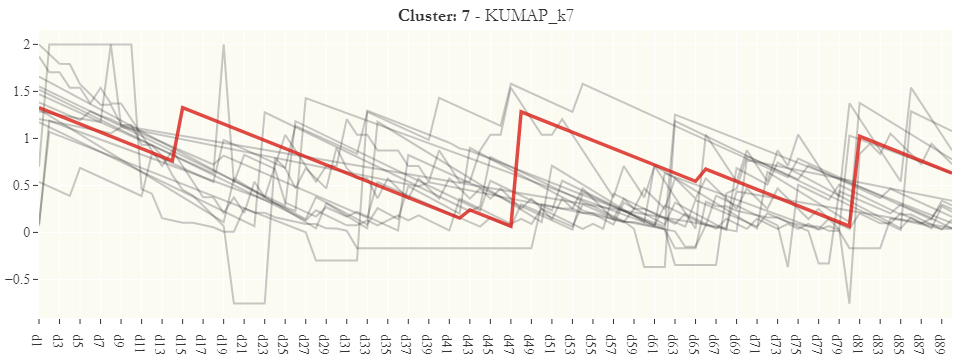

In [44]:
plot_cluster_samples(DTAI_kMedoids_centres, df_data, alg = 'KUMAP', k = 'k7', cluster=7, sample=15, seed=42)

---
# kMedoids  - DTW
https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.clustering.k_medoids.TimeSeriesKMedoids.html#sktime.clustering.k_medoids.TimeSeriesKMedoids.fit_predict

In [26]:
# sol_cols = pl.scan_csv(sol_location).columns[5:]
# # Calc total number of clusters
# max_c = int(sol_cols[-1].split('_')[-1][1:])
# algo_types = len(set([sol.split('_')[0] for sol in sol_cols]))
# total_c = int(algo_types * (max_c * (max_c + 1) / 2) - 2)

# # initiating lists
# centroids = []
# algorithms = []
# k = []
# clusters = []
# avg_scores = []
# total_scores = []
# n_w_cluster = []
# i = 0
# for s, sol in enumerate(sol_cols):
#     # Getting range of clusters for sol
#     c_min = 1
#     c_max = int(sol.split('_')[-1][1:]) # pl.scan_csv(sol_location).select(pl.max(f'{sol}')).collect().item()

#     # Calculating Centroid/Barycenter per cluster per sol.
#     for c in range(c_min, c_max + 1):
#         i += 1
#         print(f'Processing {sol} ({i}/{total_c})', end='\r')
#         # print(f'\n{process}', end='\r')
#         # Getting relevant windows (cluster points)
#         df_sol_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == c).select(["short_ID", "window_ID"]).collect()
#         df_sol = df_sol_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
#         sol_data = df_sol[window_cols][:100].values
        
#         n_w_cluster.append(len(sol_data))

        
#         # Calculating cluster centre
#         kMedoids = TimeSeriesKMedoids(n_clusters = 1, metric = 'dtw', max_iter = 10, tol = 0.001)
#         kMedoids_model = kMedoids.fit(sol_data)
#         centroid = kMedoids_model.cluster_centers_.ravel()
#         # Saving cluster centre
#         centroids.append(centroid)
        
#         # Saving Algorithm and k values
#         algorithms.append(sol.split('_')[0])
#         k.append(sol.split('_')[-1])
#         clusters.append(c)
        
#         # Calculating Average Score for respective metric
#         scores = []
#         for window in sol_data:
#             score = dtw_dist(centroid, window)
#             scores.append(score)
#         total_scores.append(np.sum(np.abs(scores)))
#         avg_scores.append(np.mean(np.abs(scores)))
        
        
# kMedoids_centres = pd.DataFrame(centroids, columns=window_cols)
# kMedoids_centres.insert(0, "cluster", clusters)
# kMedoids_centres.insert(0, "k", k)
# kMedoids_centres.insert(0, "Algorithm", algorithms)
# kMedoids_centres.insert(3, "Avg_Score", avg_scores)
# kMedoids_centres.insert(3, "Total_Score", total_scores)
# kMedoids_centres.insert(3, "Cluster_Size", n_w_cluster)

In [27]:
# kMedoids_centres.head(9)

In [28]:
# plot_elbow(kMedoids_centres, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

In [29]:
# plot_centers(kMedoids_centres, alg='KUMAP', k = 'k10')

---
# DTAI "kMedoids"  - DTW


In [30]:
# sol_cols = pl.scan_csv(sol_location).columns[5:]
# # Calc total number of clusters
# max_c = int(sol_cols[-1].split('_')[-1][1:])
# algo_types = len(set([sol.split('_')[0] for sol in sol_cols]))
# total_c = int(algo_types * (max_c * (max_c + 1) / 2) - 2)

# # initiating lists
# centroids = []
# dtai_kmedoids = []
# algorithms = []
# k = []
# clusters = []
# avg_scores = []
# total_scores = []
# n_w_cluster = []
# i = 0
# for s, sol in tqdm(enumerate(sol_cols), total=len(sol_cols),desc= 'Total Progress', leave = True, unit="epoch"):
#     # Getting range of clusters for sol
#     c_min = 1
#     c_max = int(sol.split('_')[-1][1:]) # pl.scan_csv(sol_location).select(pl.max(f'{sol}')).collect().item()

#     # Calculating Centroid/Barycenter per cluster per sol.
#     for c in tqdm(range(c_min, c_max + 1), desc= f'{sol}', leave = False, unit="epoch"):
#         i += 1
#         # Getting relevant windows (cluster points)
#         df_sol_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == c).select(["short_ID", "window_ID"]).collect()
#         df_sol = df_sol_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
#         sol_data = df_sol[window_cols].values
        
#         n_w_cluster.append(len(sol_data))

        
#         # Calculating cluster centre (DTW)
#         centroid = dba_centre(sol_data, max_it=10, thr=0.001, use_c=True)
#         # Saving cluster centre
#         centroids.append(centroid)
       
#         # Saving Algorithm and k values
#         algorithms.append(sol.split('_')[0])
#         k.append(sol.split('_')[-1])
#         clusters.append(c)
        
#         # Calculating cluster centre (kMedoid)
#         scores = []
#         for window in sol_data:
#             score = dtw_dist(centroid, window)
#             scores.append(score)
#         idx_min = np.argmin(np.abs(scores))
#         dtai_kmedoid = sol_data[idx_min]
#         dtai_kmedoids.append(dtai_kmedoid)
        
#         # Calculating Average Score for respective metric
#         scores = []
#         for window in sol_data:
#             score = dtw_dist(dtai_kmedoid, window)
#             scores.append(score)
#         total_scores.append(np.sum(np.abs(scores)))
#         avg_scores.append(np.mean(np.abs(scores)))
      
        
# DTAI_kMedoids_centres = pd.DataFrame(dtai_kmedoids, columns=window_cols)
# DTAI_kMedoids_centres.insert(0, "cluster", clusters)
# DTAI_kMedoids_centres.insert(0, "k", k)
# DTAI_kMedoids_centres.insert(0, "Algorithm", algorithms)
# DTAI_kMedoids_centres.insert(3, "Avg_Score", avg_scores)
# DTAI_kMedoids_centres.insert(3, "Total_Score", total_scores)
# DTAI_kMedoids_centres.insert(3, "Cluster_Size", n_w_cluster)

In [31]:
# DTAI_kMedoids_centres.head(9)

In [32]:
# plot_elbow(DTAI_kMedoids_centres, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

In [33]:
# plot_centers(DTAI_kMedoids_centres, alg='KUMAP', k = 'k11')

In [34]:
# plot_cluster_samples(DTAI_kMedoids_centres, df_data, alg = 'KUMAP', k = 'k11', cluster=1, sample=10, seed=None)

---
# Saving Results

## Euclidean

In [35]:
solution_fileName = f'{solution_name}-Euc_Centers.csv'
solution_fileName

'CNN_ConvEmb-vague_sweep_1_v41-Euc_Centers.csv'

In [36]:
os.makedirs(f'../ModelResults/Clustering/Centroids/{dataset_name}', exist_ok=True)  
Euclidean_centres.to_csv(f'../ModelResults/Clustering/Centroids/{dataset_name}/{solution_fileName}', index=False)

## DTW

In [37]:
solution_fileName = f'{solution_name}-DTW_Centers.csv'
solution_fileName

'CNN_ConvEmb-vague_sweep_1_v41-DTW_Centers.csv'

In [38]:
os.makedirs(f'../ModelResults/Clustering/Centroids/{dataset_name}', exist_ok=True)  
DTW_centres.to_csv(f'../ModelResults/Clustering/Centroids/{dataset_name}/{solution_fileName}', index=False)

## kMedoid(DTW)

In [39]:
solution_fileName = f'{solution_name}-kMedoid_DTW_Centers.csv'
solution_fileName

'CNN_ConvEmb-vague_sweep_1_v41-kMedoid_DTW_Centers.csv'

In [40]:
os.makedirs(f'../ModelResults/Clustering/Centroids/{dataset_name}', exist_ok=True)  
DTAI_kMedoids_centres.to_csv(f'../ModelResults/Clustering/Centroids/{dataset_name}/{solution_fileName}', index=False)